### NxN Resolution Image based FULL Bayes

This code works exactly same as Full bayes, but the difference is that the Prediction is done over multiple resolution images instead of just 1x1 image. We try to calculate accuracies on 2x2, 4x4, 8x8, 16x16 and 32x32. Though computing for last two is computationally very expensive but the code still works. Finally, we plot the graph to observe the changes in accuracies. 

After some point the accuracy collapses as we don’t anymore have enough data points to robustly esimate the covariance matrix.

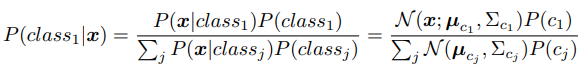

in which x = (mR, mG, mB)<sup>T</sup>
is a three-dimensional vector

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from skimage import transform
from scipy.stats import norm
from scipy.stats import multivariate_normal

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding="latin1")
    return dict

datadict_tst = unpickle(r'/cifar-10/test_batch') #Loads all unpickled raw Test data in datadict_tst variable

def Load_Data(Data_sets):
    LBL=[]
    for i in range(1, Data_sets+1):

        path='/cifar-10/data_batch_{}'.format(i)
        Load = unpickle(r'{}'.format(path))
        DAT=Load["data"]           
        LBL+=Load["labels"]
        if i == 1:           
            Da=Load["data"]           
        else:
            Da=np.vstack([Da, DAT])           
#    print("Data Shape:",Da.shape)
    LBL = np.array(LBL)
#    print("Label Shape:",LBL.shape)
    return Da,LBL


X1,Y=Load_Data(5) #Load All 5 data sets into X1 and Labels in Y
X_Pic = X1.reshape(X1.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

Q1a = datadict_tst["data"]
Q_Label = datadict_tst["labels"]

Q_Label = np.array(Q_Label)  ## contains class numbers for each image to tell which img belongs to which class
Q_TST_Pic = Q1a.reshape(Q1a.shape[0], 3, 32, 32).transpose(0,2,3,1).astype("float") #Reshape the 10K images into 3 32 X 32 grids. (for RGBs)
                                                                    #Now, transpose this with the given axis.

print('All Datasets Loaded')
print("X Dataset's Dimensions:" ,X_Pic.shape)
print("Q Test Dataset's Dimensions:" ,Q_TST_Pic.shape)

print('========================================================================')


All Datasets Loaded
X Dataset's Dimensions: (50000, 32, 32, 3)
Q Test Dataset's Dimensions: (10000, 32, 32, 3)


This Block calculates the class accuracy and also performs transformations on our data array. Since data image is 3072 byte long vector, we need to reshape each image to 1x1x3 format. Now, Images will be of only 1 pixel!

In [2]:
#%timeit -r1 -n1


def class_acc(pred,gt): #This function will compare the Labels that were predicted using any 
                        #classifier (such as Random or 1NN) to Original labels that came with dataset (our ground truth)
                        #and will give us an accuracy estimate of our program.
    err=0            #will store number of mismatches
    accuracy=0          #wil be used to calculate accuracy
    for i in range(0,len(gt)): #Loop to iterate through all ground truth variables and compare with pred.
        if gt[i]!=pred[i]:     #comparing each Pred label to gt label
            err=err+1;         #increment the error counter

    accuracy=(len(pred)-err)/(len(pred)) #calculate the accuracy ((totalpts-error)/totalpts)*100(for %)
    accuracyPercentage=accuracy*100
    return accuracyPercentage

#==========================================================================================NXN FULL BAYES
def cifar10_NxN_color(X,wndw):  #converts the original images in X (50000 ×32 ×32 ×3) to Xp (50000 NXNX3)
    resized_x = transform.resize(X, (X.shape[0], wndw, wndw, 3), order=1, mode='constant', anti_aliasing=True).reshape(X.shape[0], wndw*wndw,3)
    return resized_x

This block provides a helper function to sort all images according to their classes from 0 to 9. Since we know all classes have perfectly 5000 images, we can use this knowledge while calculating mean and variances in later sections.

In [3]:
def class_Sorter(Xs,Ys):
    values=[]
    print("Sorting Resized Images according to their Labels")
    for i in range(Xs.shape[0]): #run as many times as data pts in Xp array 
        values.append((Xs[i],Ys[i])) #mark all Scaled images with their Labels in single array with Y array (containing labels)      

    values = sorted(values,key = lambda x:x[1])
    values=np.asarray(values)[:,0]  #Fetch all values without class numbers (since they are already sorted and we know exact count...)
    values = np.stack( values, axis=0 )  #Combine arrays of all Images with columns representing R,G,B channels

    return values

#### If window = 2

This function computes the multivariate normal distribution parameters (mean, covariance, priors) for all 10 classes. **Mean** will be 10 x (window x window x 3) that is 10x12 and **Covariance**: 10 x (window x window x 3) x (window x window x 3) that is 10x12x12 and **priors**: 10x1. 

In [4]:
#==========================================================================================NXN FULL BAYES

def cifar_10_bayes_learn_NXN(X,Y,wndw):

    Sorted_values=class_Sorter(X,Y)
    
    result_Classes_MU2 = np.empty((0,wndw*wndw*3), float)
    result_Classes_COVA2 = np.empty((0,wndw*wndw*3,wndw*wndw*3), float)
    
    batch = 5000  #max. number of sorted images per class.
    
    for s in range(0,len(Sorted_values),batch):
        #print("Process Images from", i, "to", batch+i)
        Channel_R = Sorted_values[s:batch+s,:,0] #Red channels for all images each image is 2x2, so,4 dims. (5000xwindow_size) R channel
        Channel_G = Sorted_values[s:batch+s,:,1] #Red channels for all images each image is 2x2, so,4 dims. (5000xwindow_size) R channel
        Channel_B = Sorted_values[s:batch+s,:,2] #Red channels for all images each image is 2x2, so,4 dims. (5000xwindow_size) R channel

        meanR = np.mean(Channel_R,axis=0)  #window_size(4 in this case) values of mean
        meanG = np.mean(Channel_G,axis=0)
        meanB = np.mean(Channel_B,axis=0)
        
        Channel_R = Channel_R.transpose()  #Transpose to keep images together in row (windowsize X 5000)
        Channel_G = Channel_G.transpose()  #Transpose to keep images together in row (windowsize X 5000)
        Channel_B = Channel_B.transpose()  #Transpose to keep images together in row (windowsize X 5000)

        Channel_matrix = np.array([Channel_R, Channel_G, Channel_B])  #(3, windowsize, 5000)  
        Channel_matrix = Channel_matrix.reshape( Channel_matrix.shape[0]*Channel_matrix.shape[1], Channel_matrix.shape[2] )  #(12, 5000)  
        CO_Var2 = np.cov(Channel_matrix)   #(12, 12) matrix

        #print("Covariance2:",CO_Var2.shape)
        #print(CO_Var2)
        #print(CO_Var2.shape)
        
        result_Classes_MU2 = np.append(result_Classes_MU2, np.array([[meanR,meanG,meanB]]))  #mean will be 12x1 per class
        result_Classes_COVA2 = np.append(result_Classes_COVA2,[CO_Var2],axis=0)     #covariance will be 12x12 per class

    result_Classes_Prior = np.repeat(0.1, 10)  #create array containing 0.1 for 10 classes
    result_Classes_MU2=result_Classes_MU2.reshape(10, wndw*wndw*3)

    #print("MU2's Shape",result_Classes_MU2.shape)
    #print("MU2's values",result_Classes_MU2)
    
    #print("NXN Covariance2 Matrix's Shape",result_Classes_COVA2.shape)
    #print("NXN Covariance2 Matrix's values",result_Classes_COVA2)
    
    return result_Classes_MU2, result_Classes_COVA2, result_Classes_Prior


This block will calculate the probabilities by implementing the following formula.

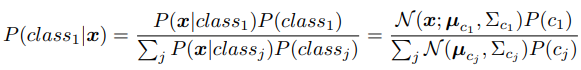

In [12]:
def cifar10_classifier_bayes_NXN(tst,mu,cov,p,wndw):
    Total_Dr=0.0
    all_NR=[]
    for i in range(0,10):
        tst=np.transpose(tst)
        tst=tst.reshape(wndw * wndw * 3)
        
        Dr_Data=multivariate_normal.pdf(tst, mu[i], cov[i])
        #print()
        #print("Class-",i)
        #print("Data's Shape",Dr_Data.shape)
        #print("Data",Dr_Data)
        #print("------------------------")
        
        Data=(Dr_Data)*p[i]
        Total_Dr=Total_Dr+Data
        all_NR.append(Data)

    all_NR=np.asarray(all_NR)
    out = np.divide(all_NR, Total_Dr)
    Estimated_Img_class=out.argmax(axis=0) 
    #print("Data: ",Data)
    #print("Total_Dr: ",Total_Dr)
    #print("all_NR: ",all_NR)
    
    #print("Outs: ",out)
    #print("Estimated_Img_class: ",Estimated_Img_class)
    
    return Estimated_Img_class

def batch_bayes_NXN(TST,Mew,cov,pri3,wndw): #tst sample scaled img array containing test imgs.#MU, SIG, Prior calculated earlier
    bayes_labels=np.array([])
    for i in range(TST.shape[0]):
        OP=cifar10_classifier_bayes_NXN(TST[i],Mew,cov,pri3,wndw)
        bayes_labels = np.append(bayes_labels,OP)
        #if wndw > 8:
            #print("Image:", i) #Images processed    
        #print("Full Bayes Predicted Label's Shape is: ",bayes_labels.shape) #verify the shape of predicted labels
    return bayes_labels  



Function to Test Run at window sizes 

In [6]:
def Batch_RUN(WINDOW_SIZE):
    
    #============================================================================ Resizing Images
    #============================================================================ Resizing Images
    print("#========= Resizing Images to:",WINDOW_SIZE,"X",WINDOW_SIZE)
    RESIZE_NXN_DATA=cifar10_NxN_color(X_Pic,WINDOW_SIZE)
    RESIZE_NXN_TST=cifar10_NxN_color(Q_TST_Pic,WINDOW_SIZE)

    print("Resized NXN DATA Batch's Dimensions:" ,RESIZE_NXN_DATA.shape)
    print("Resized NXN TEST Batch's Dimensions:" ,RESIZE_NXN_TST.shape)
    print()


    #========= Training FULL bayes AT NXN to fetch Mu,Covariance etc..
    #========= Training FULL bayes AT NXN to fetch Mu,Covariance etc..

    print("#========= Training FULL Bayes:",WINDOW_SIZE,"X",WINDOW_SIZE)
    MU3,COV2,PRIOR3=cifar_10_bayes_learn_NXN(RESIZE_NXN_DATA,Y,WINDOW_SIZE) #<<Learn

    print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes MU's Shape",MU3.shape)
    print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes Covariance's Shape",COV2.shape)
    print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes Prior's Shape",PRIOR3.shape)
    print()


    #========= RUNNING FULL BAYES at NXN AND FETCHING ACCURACY

    print("#========= RUNNING FULL BAYES at",WINDOW_SIZE,"X",WINDOW_SIZE,"AND FETCHING ACCURACY")
    BATCH_bayes_full_NXN=batch_bayes_NXN(RESIZE_NXN_TST,MU3,COV2,PRIOR3,WINDOW_SIZE) #<< Classify TEST

    BATCH_bayes_full_Acc_NXN=class_acc(BATCH_bayes_full_NXN,Q_Label)   #<<Calculate accuracy
    print(WINDOW_SIZE,"X",WINDOW_SIZE,"Full Bayes Accuracy in %: ",BATCH_bayes_full_Acc_NXN)
    print()
    print("------------------------------------------------------------------------------------------------------------")
    return BATCH_bayes_full_Acc_NXN


**Test Run at 2x2 window**

In [13]:
WINDOW_SIZE = 2

#============================================================================ Resizing Images
#============================================================================ Resizing Images
print("#========= Resizing Images to:",WINDOW_SIZE,"X",WINDOW_SIZE)
RESIZE_NXN_DATA=cifar10_NxN_color(X_Pic, WINDOW_SIZE)
RESIZE_NXN_TST=cifar10_NxN_color(Q_TST_Pic,WINDOW_SIZE)

print("Resized NXN DATA Batch's Dimensions:" ,RESIZE_NXN_DATA.shape)
print("Resized NXN TEST Batch's Dimensions:" ,RESIZE_NXN_TST.shape)
print()




#========= Training FULL bayes AT NXN to fetch Mu,Covariance etc..

print("#========= Training FULL Bayes:",WINDOW_SIZE,"X",WINDOW_SIZE)

MU3,COV2,PRIOR3 = cifar_10_bayes_learn_NXN(RESIZE_NXN_DATA, Y, WINDOW_SIZE)

print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes MU's Shape",MU3.shape)
print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes Covariance's Shape",COV2.shape)
print(WINDOW_SIZE,"X",WINDOW_SIZE,"Bayes Prior's Shape",PRIOR3.shape)
print()



#========= RUNNING FULL BAYES at NXN AND FETCHING ACCURACY

print("#========= RUNNING FULL BAYES at",WINDOW_SIZE,"X",WINDOW_SIZE,"AND FETCHING ACCURACY")

BATCH_bayes_full_NXN = batch_bayes_NXN(RESIZE_NXN_TST, MU3, COV2, PRIOR3, WINDOW_SIZE) #<< Classify TEST

BATCH_bayes_full_Acc_NXN = class_acc(BATCH_bayes_full_NXN,Q_Label)   #<<Calculate accuracy
print(WINDOW_SIZE,"X",WINDOW_SIZE,"Full Bayes Accuracy in %: ",BATCH_bayes_full_Acc_NXN)
print()
print("------------------------------------------------------------------------------------------------------------")

#========= Resizing Images to: 2 X 2
Resized NXN DATA Batch's Dimensions: (50000, 4, 3)
Resized NXN TEST Batch's Dimensions: (10000, 4, 3)

#========= Training FULL Bayes: 2 X 2
Sorting Resized Images according to their Labels
2 X 2 Bayes MU's Shape (10, 12)
2 X 2 Bayes Covariance's Shape (10, 12, 12)
2 X 2 Bayes Prior's Shape (10,)

#========= RUNNING FULL BAYES at 2 X 2 AND FETCHING ACCURACY
2 X 2 Full Bayes Accuracy in %:  31.069999999999997

------------------------------------------------------------------------------------------------------------


**Run and Get Accuracy**

Batch run at multiple window sizes and observe where the accuracy drops.

0
#========= Resizing Images to: 2 X 2
Resized NXN DATA Batch's Dimensions: (50000, 4, 3)
Resized NXN TEST Batch's Dimensions: (10000, 4, 3)

#========= Training FULL Bayes: 2 X 2
Sorting Resized Images according to their Labels
2 X 2 Bayes MU's Shape (10, 12)
2 X 2 Bayes Covariance's Shape (10, 12, 12)
2 X 2 Bayes Prior's Shape (10,)

#========= RUNNING FULL BAYES at 2 X 2 AND FETCHING ACCURACY
2 X 2 Full Bayes Accuracy in %:  31.069999999999997

------------------------------------------------------------------------------------------------------------
1
#========= Resizing Images to: 3 X 3
Resized NXN DATA Batch's Dimensions: (50000, 9, 3)
Resized NXN TEST Batch's Dimensions: (10000, 9, 3)

#========= Training FULL Bayes: 3 X 3
Sorting Resized Images according to their Labels
3 X 3 Bayes MU's Shape (10, 27)
3 X 3 Bayes Covariance's Shape (10, 27, 27)
3 X 3 Bayes Prior's Shape (10,)

#========= RUNNING FULL BAYES at 3 X 3 AND FETCHING ACCURACY
3 X 3 Full Bayes Accuracy in %:  39.89



C:\Users\osama\AppData\Local\Temp/ipykernel_19824/2364327110.py:20: RuntimeWarning: invalid value encountered in true_divide
  out = np.divide(all_NR, Total_Dr)


4 X 4 Full Bayes Accuracy in %:  40.28

------------------------------------------------------------------------------------------------------------
3
#========= Resizing Images to: 8 X 8
Resized NXN DATA Batch's Dimensions: (50000, 64, 3)
Resized NXN TEST Batch's Dimensions: (10000, 64, 3)

#========= Training FULL Bayes: 8 X 8
Sorting Resized Images according to their Labels
8 X 8 Bayes MU's Shape (10, 192)
8 X 8 Bayes Covariance's Shape (10, 192, 192)
8 X 8 Bayes Prior's Shape (10,)

#========= RUNNING FULL BAYES at 8 X 8 AND FETCHING ACCURACY
8 X 8 Full Bayes Accuracy in %:  35.07

------------------------------------------------------------------------------------------------------------
[31.069999999999997, 39.89, 40.28, 35.07]


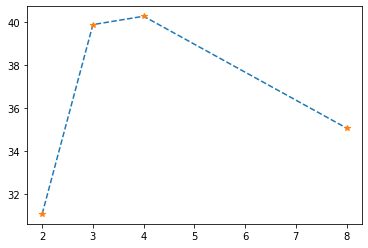

In [15]:
#============================================================================ Resizing Images
#============================================================================ Resizing Images
Accuracy_List=[]

for i in range (0,6):
    window = 2**i
    Accuracy_List.append(Batch_RUN(window))
    
print(Accuracy_List)

# Plotting the accuracy data over the window sizes
ZZ =[1,2,4,8,16,32]
plt.figure()
plt.plot(ZZ,Accuracy_List,'--')
plt.plot(ZZ,Accuracy_List,'*')

plt.show()